In [64]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
from reservoirpy.observables import nrmse, rsquare

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

外力がより複雑な場合を考えてみる。
試しに、外力の項がローレンツシステムのx成分であるときを考えてみる。

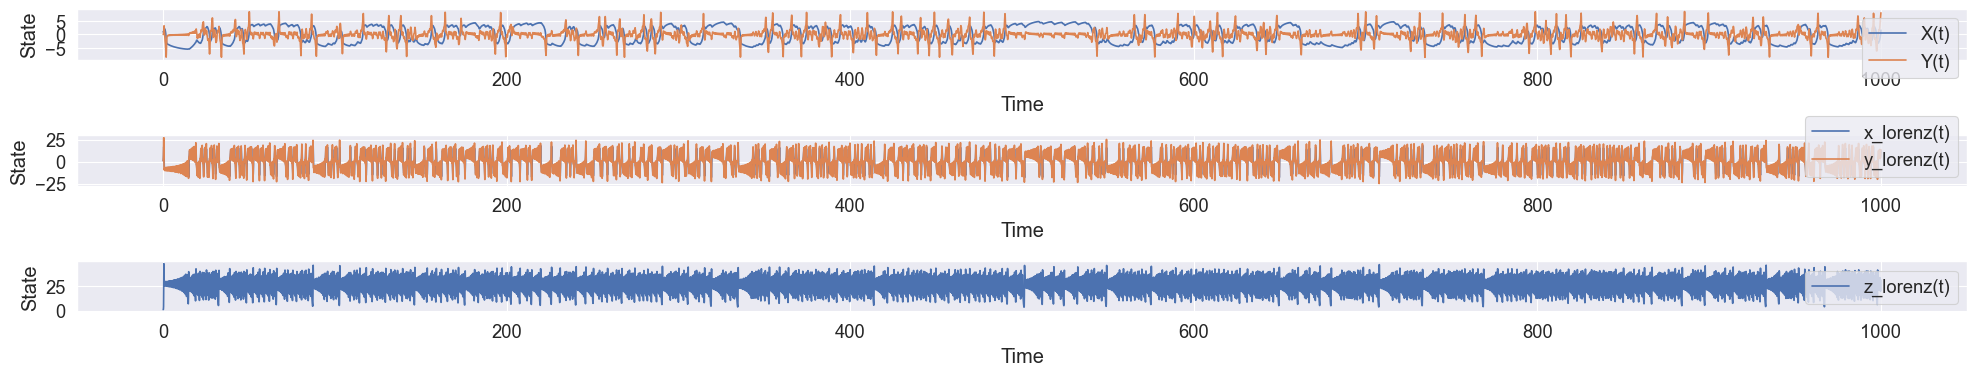

In [65]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def coupled_system(t, state, mu, sigma, rho, beta):
    X, Y, x_lorenz, y_lorenz, z_lorenz = state
    
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + x_lorenz
    
    dx_lorenz_dt = sigma * (y_lorenz - x_lorenz)
    dy_lorenz_dt = x_lorenz * (rho - z_lorenz) - y_lorenz
    dz_lorenz_dt = x_lorenz * y_lorenz - beta * z_lorenz
    
    return [dXdt, dYdt, dx_lorenz_dt, dy_lorenz_dt, dz_lorenz_dt]

mu = 1.0
sigma = 10.0
rho = 28.0
beta = 8/3
initial_state = [1.0, 0.0, 1.0, 1.0, 1.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]
t_span = (0, 1000)

sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, sigma, rho, beta), t_eval=np.linspace(t_span[0], t_span[1], 10000))

# Plot the results
plt.figure(figsize=(20, 4))

plt.subplot(3, 1, 1)
plt.plot(sol.t, sol.y[0], label='X(t)')
plt.plot(sol.t, sol.y[1], label='Y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(sol.t, sol.y[2], label='x_lorenz(t)')
plt.plot(sol.t, sol.y[3], label='y_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sol.t, sol.y[4], label='z_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()


In [66]:
data = pd.DataFrame({
    'Time': sol.t,
    'X': sol.y[0],
    'Y': sol.y[1],
    'x_lorenz': sol.y[2],
    'y_lorenz': sol.y[3],
    'z_lorenz': sol.y[4]
})

# DataFrameをCSVファイルに保存
data.to_csv('coupled_system_dataset.csv', index=False)

In [67]:
data_loaded = pd.read_csv('forced_vanderpol_dataset.csv')

In [68]:
X = data.values

In [69]:
X

array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00],
       [1.00010001e-01, 1.00095630e+00, 3.78727253e-02, 2.13333131e+00,
        4.47197977e+00, 1.11394353e+00],
       [2.00020002e-01, 1.01578928e+00, 3.30914780e-01, 6.53674299e+00,
        1.37100231e+01, 4.17683595e+00],
       ...,
       [9.99799980e+02, 1.21129191e-01, 6.25516949e+00, 5.96858509e+00,
        8.36469376e+00, 1.94254696e+01],
       [9.99899990e+02, 8.08096259e-01, 7.46723055e+00, 9.18481031e+00,
        1.30137583e+01, 2.20969499e+01],
       [1.00000000e+03, 1.59463216e+00, 8.05167502e+00, 1.22604653e+01,
        1.34945851e+01, 3.04999750e+01]])

In [70]:
def plot_vanderpol_2d(X, timesteps):
    # 2D プロットの作成
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Van Der Pol Oscillator (xy plane)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # 軌跡の描画
    for i in range(timesteps-1):
        ax.plot(X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//timesteps), lw=1.0)

    plt.show()


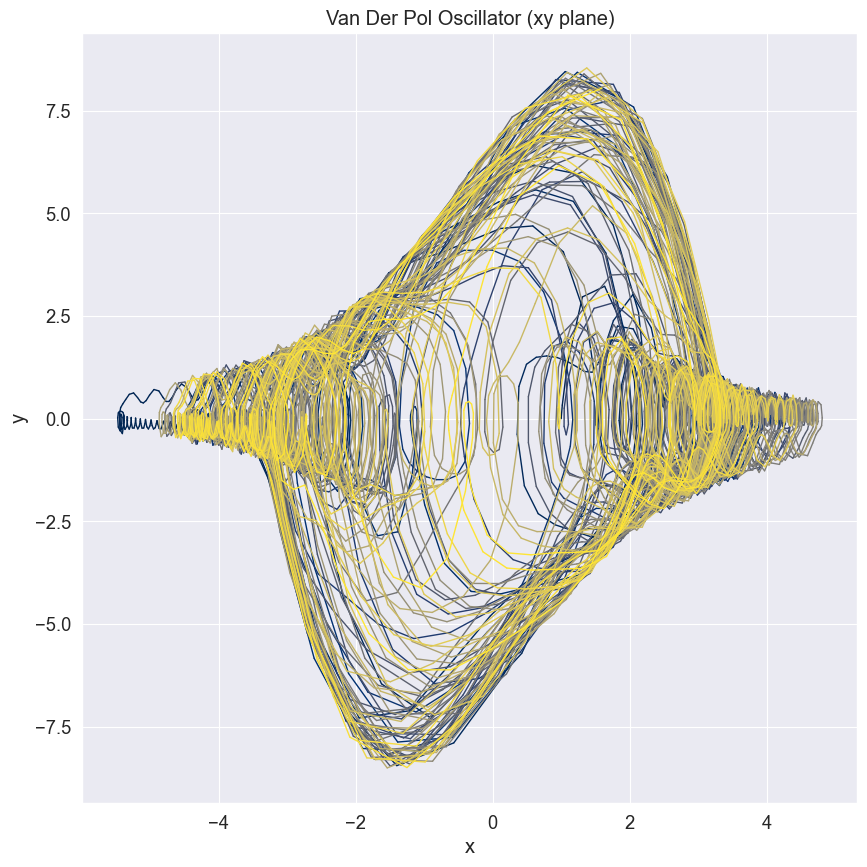

In [71]:
plot_vanderpol_2d(X, 10000)

In [72]:
def plot_vanderpol_3d(X, timesteps):
    # 3D プロットの作成
    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(111, projection='3d')
    ax.set_title("Van Der Pol Oscillator Result")
    ax.set_xlabel("t")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.grid(False)

    for i in range(timesteps-1):
        ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//timesteps), lw=1.0)

    plt.show()

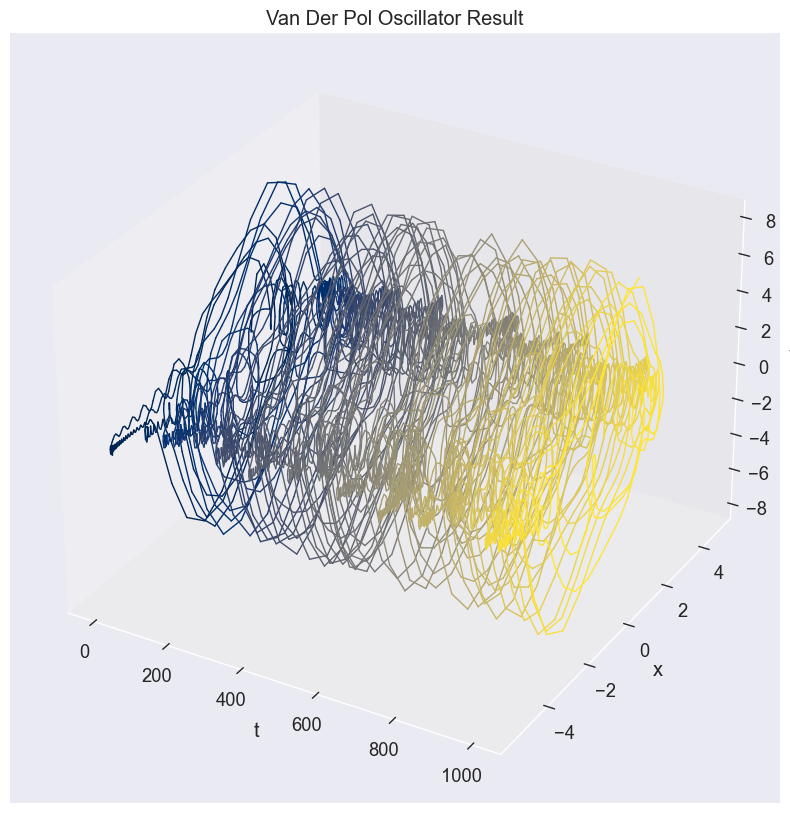

In [73]:
plot_vanderpol_3d(X, 10000)

In [74]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, connectivity, ridge, noise_rc, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              rc_connectivity=connectivity,
                              input_scaling=iss,
                              noise_rc=noise_rc, noise_type="normal", 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [75]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling is fixed
        "ridge": ["loguniform", 1e-10, 1],        # and so is the regularization parameter.
        "connectivity": ["uniform", 0, 1], # the connectivity of the random network in the hidden layer uniformly distributed between 0 and 1.
        "noise_rc": ["loguniform", 1e-5, 1], #noise amplitude is log-uniformly distributed between 1e-5 and 1
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [76]:
train_len = 2000

X_train = X[:train_len]
y_train = X[1 : train_len + 1]

X_test = X[train_len : -1]
y_test = X[train_len + 1:]

dataset = ((X_train, y_train), (X_test, y_test))

In [77]:
%time 

from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.67 µs
 11%|█         | 22/200 [02:14<18:10,  6.12s/trial, best loss: 0.9566389918354149]


KeyboardInterrupt: 

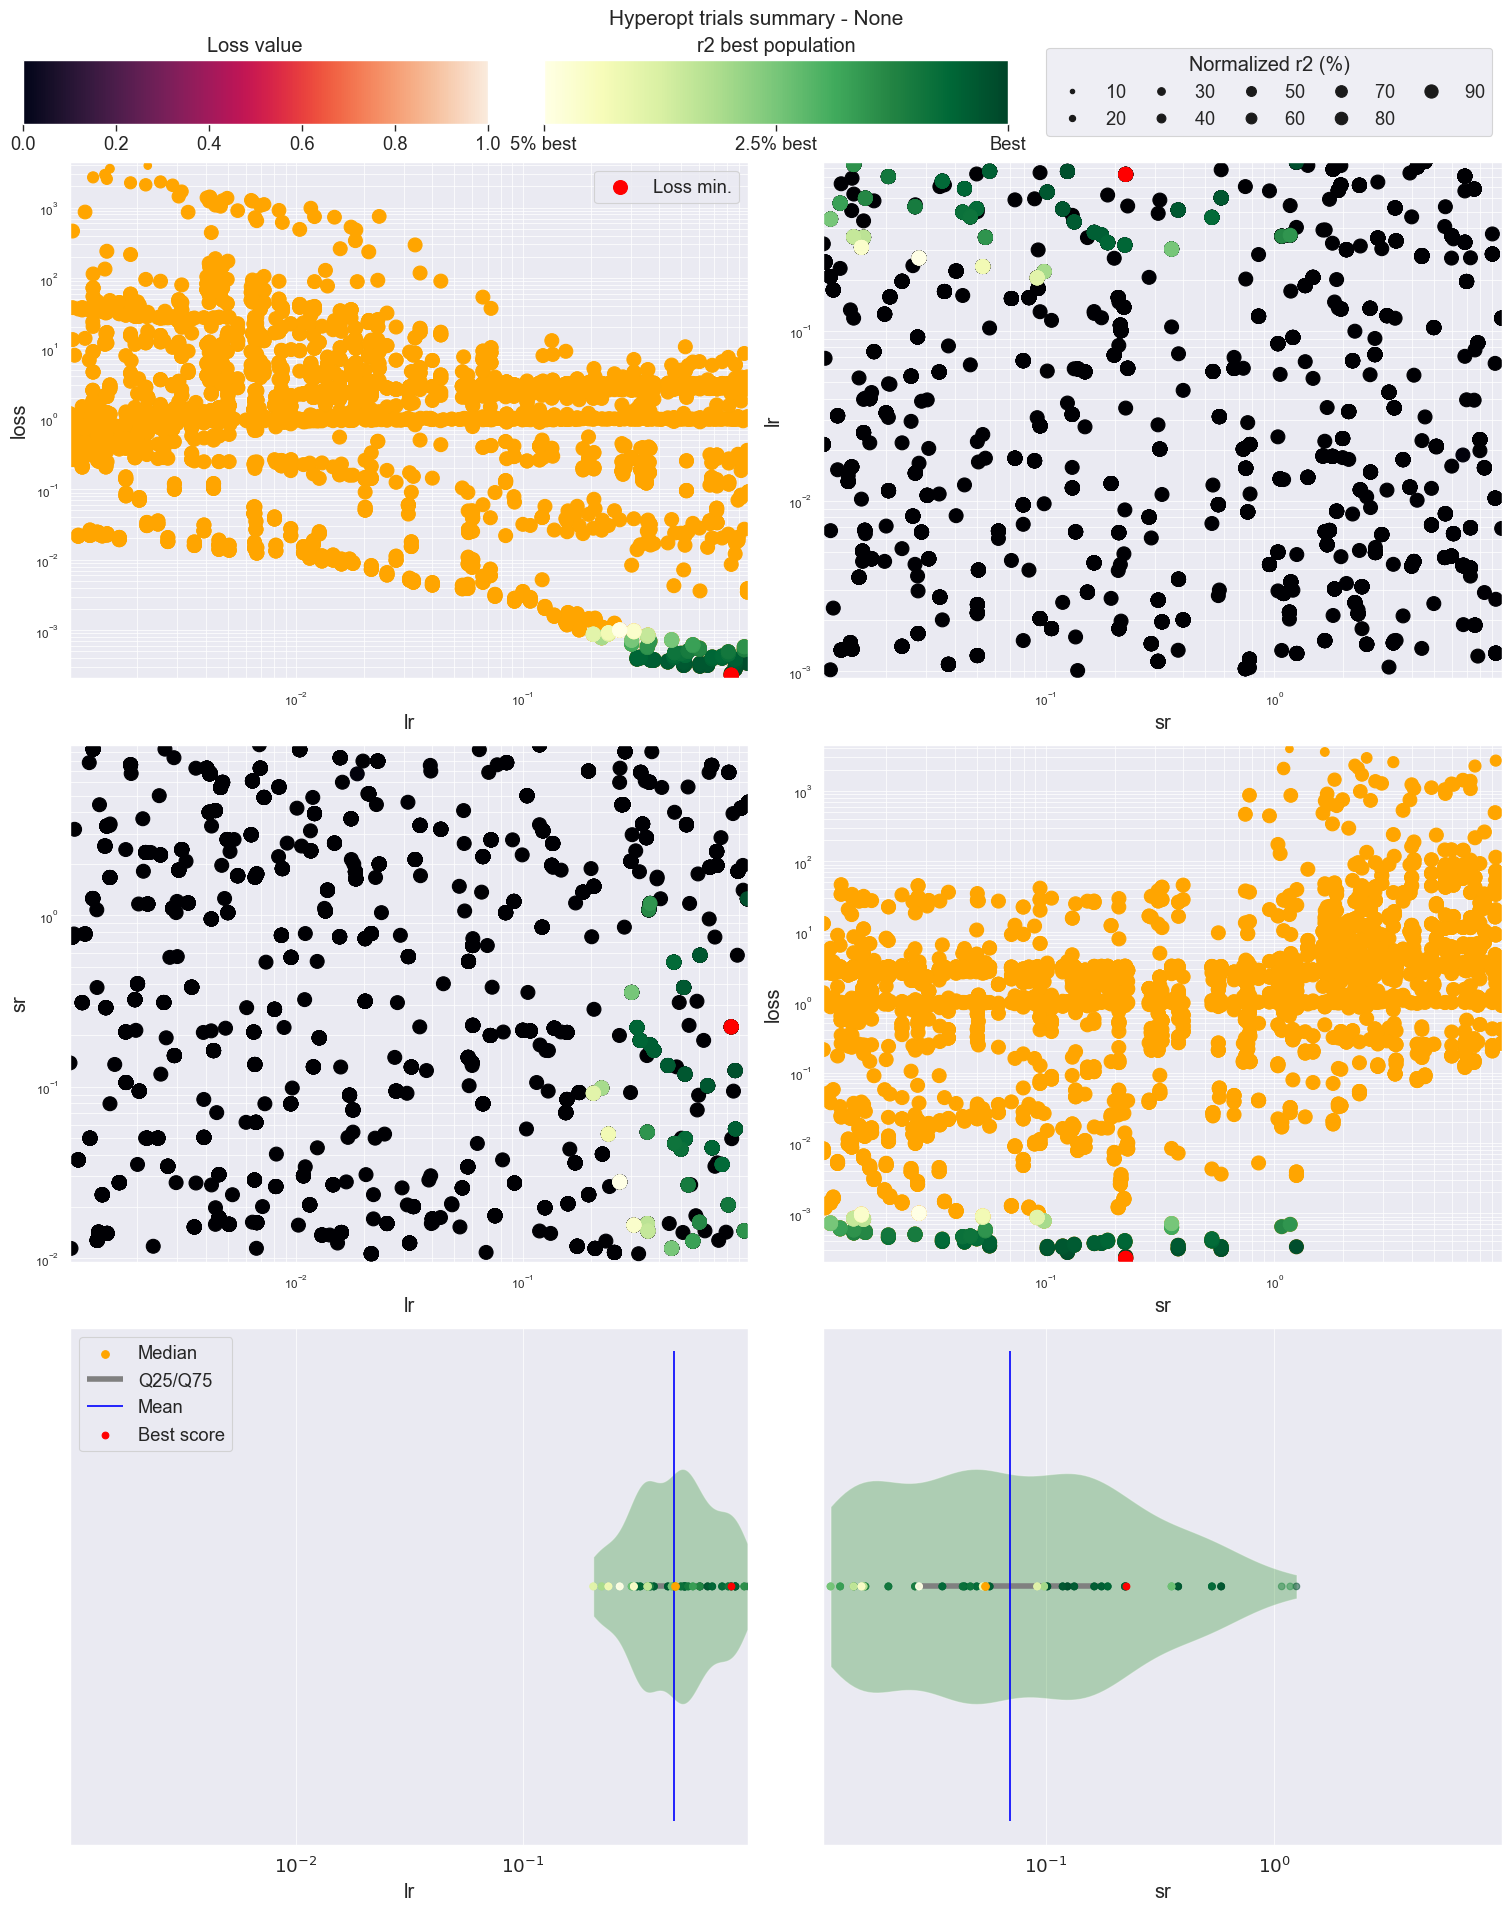

In [ ]:
from reservoirpy.hyper import plot_hyperopt_report

fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr"), metric="r2")

In [ ]:
best

({'N': 0,
  'connectivity': 0.8202041368713199,
  'iss': 0.3547992325623448,
  'lr': 0.0015879865199761832,
  'noise_rc': 1.4446576598938763e-05,
  'ridge': 5.36043117633386e-08,
  'seed': 0,
  'sr': 0.13504276379966784},
 <hyperopt.base.Trials at 0x169b0a8b0>)

In [84]:
units = 500
leak_rate = 0.17113764962939737
spectral_radius = 1.182082887824895
input_scaling = 0.9697295578201843
connectivity = 0.10407566959031667      # - density of reservoir internal matrix
input_connectivity = 0.2  # and of reservoir input matrix
regularization = 5.602814683095597e-09
noise_rc = 3.297333463106559e-05
seed = 1234             # for reproducibility

In [85]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout


In [86]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed, 
                      noise_rc=noise_rc, noise_type="normal")

readout   = Ridge(1, ridge=regularization)

esn = reservoir >> readout

In [87]:
y = esn(X[0])  # initialisation
reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None

(True, True, True)

In [88]:
np.all(readout.Wout == 0.0)

True

In [90]:
esn = esn.fit(X_train, y_train).run(X_test)

ValueError: Ridge-673is  expecting data of shape (1,) but received shape (6,).

array([0.10001   , 1.0009563 , 0.03787273, 2.13333131, 4.47197977,
       1.11394353])